<a href="https://colab.research.google.com/github/nedokormysh/GB_DA_algorithms/blob/lesson4/DA_algorithms_hw_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import numpy as np

# Задание 1.

В коде из методички реализуйте один или несколько критериев останова: количество листьев, количество используемых признаков, глубина дерева и т. д.

In [11]:
classification_data, classification_labels = datasets.make_classification(n_samples=500, n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=5, 
                                                      flip_y=0.5)

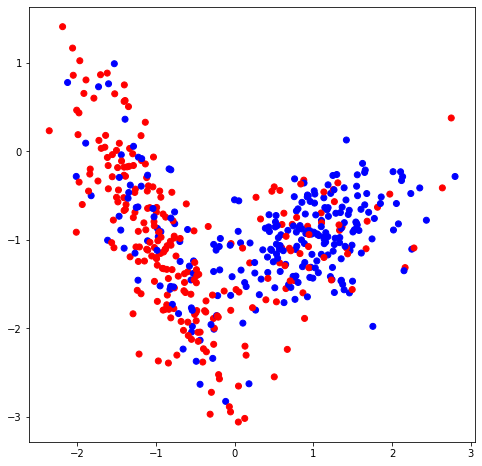

In [12]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [13]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index 
        self.t = t  
        self.true_branch = true_branch 
        self.false_branch = false_branch 

In [14]:
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels 
        self.prediction = self.predict() 
        
    def predict(self):
        
        classes = {}  
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
          
        prediction = max(classes, key=classes.get)
        return prediction 

In [15]:
def gini(labels):
    
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
        
    impurity = 1   
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [16]:
def gain(left_labels, right_labels, root_gini):

    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [17]:
def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [18]:
def find_best_split(data, labels):
    
    min_samples_leaf = 5

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue
            
            current_gain = gain(true_labels, false_labels, root_gini)
            
            
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [19]:
def build_tree(data, labels, max_depth, current_depth=0, one_class=False): 
    
    # Ограничение глубины дерева
    if current_depth ==  max_depth: 
        return Leaf(data, labels)

    quality, t, index = find_best_split(data, labels)    

    if quality == 0:
        return Leaf(data, labels)
        
    # Ограничение, если все объекты в листе одного класса
    if one_class == True:
        leaf = Leaf(data, labels)
        if len(set(leaf.labels)) == 1:
          return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    
    current_depth += 1 # увеличиваем текущее значение глубины дерева на единицу.

    true_branch = build_tree(true_data, true_labels, max_depth, current_depth) 
    false_branch = build_tree(false_data, false_labels, max_depth, current_depth)

    return Node(index, t, true_branch, false_branch)

In [20]:
def classify_object(obj, node):

    if isinstance(node, Leaf): 
        answer = node.prediction 
        return answer

    if obj[node.index] <= node.t: 
        return classify_object(obj, node.true_branch) 
    else:
        return classify_object(obj, node.false_branch) 

In [21]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree) 
        classes.append(prediction)
    return classes

In [22]:
from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [23]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [24]:
my_tree = build_tree(train_data, train_labels, max_depth=3) 

In [25]:
def print_tree(node, spacing=""):

    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 0
Порог -0.33563454471260523
--> True:
  Индекс 0
  Порог -0.8418866938943319
  --> True:
    Индекс 1
    Порог 0.6537576378760739
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 1
  --> False:
    Индекс 0
    Порог -0.5251001694401725
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 0
--> False:
  Индекс 1
  Порог -1.551394216755007
  --> True:
    Индекс 1
    Порог -1.6282226665336295
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 0
  --> False:
    Индекс 0
    Порог 0.7329350213251566
    --> True:
      Прогноз: 1
    --> False:
      Прогноз: 1


In [26]:
train_answers = predict(train_data, my_tree)

In [27]:
answers = predict(test_data, my_tree)

In [29]:
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

76.28571428571429

In [30]:
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

68.66666666666667

Text(0.5, 1.0, 'Test accuracy=68.67')

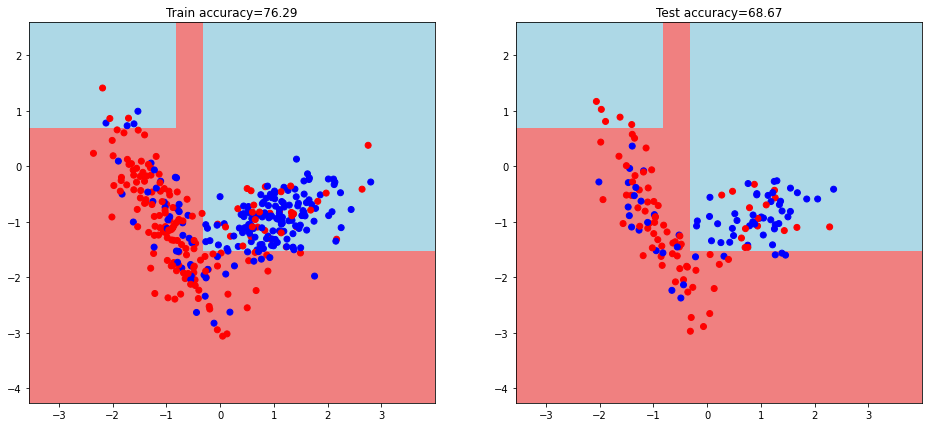

In [31]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

# Задание 2.

Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [32]:
X, Y, coef = datasets.make_regression(n_samples=1000, n_features=2, n_informative=1, n_targets=1, 
                                      noise=5, coef=True, random_state=2)

X[:, 0] *= 10

train_data, test_data, train_values, test_values = train_test_split(X, 
                                                                    Y, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [34]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  
        self.t = t 
        self.true_branch = true_branch  
        self.false_branch = false_branch  

In [35]:
class Leaf:
    
    def __init__(self, data, values):
        self.data = data
        self.values = values
        self.prediction = self.predict()
        
    def predict(self):
        # найдем среднее арифметическое от всех значений в листе и вернем его    
        prediction = np.mean(self.values)
        return prediction   

In [36]:
def variance(arr):
    return np.mean((arr - arr.mean()) ** 2)

In [37]:
def quality(left_vals, right_vals, current_variance):

    p = float(left_vals.shape[0]) / (left_vals.shape[0] + right_vals.shape[0])
    
    return current_variance - p * variance(left_vals) - (1 - p) * variance(right_vals)

In [38]:
def split(data, vals, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_vals = vals[left]
    false_vals = vals[right]
        
    return true_data, false_data, true_vals, false_vals

In [39]:
def find_best_split(data, vals):
    
    min_samples_leaf = 5

    root_variance = variance(vals)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_vals, false_vals = split(data, vals, index, t)
            
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue
            
            current_gain = gain(true_vals, false_vals, root_variance)
            
            
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [40]:
def build_tree(data, vals):

    quality, t, index = find_best_split(data, vals) 

    
    if quality == 0:
        return Leaf(data, vals) 

    true_data, false_data, true_vals, false_vals = split(data, vals, index, t)

    true_branch = build_tree(true_data, true_vals)
    false_branch = build_tree(false_data, false_vals)

    return Node(index, t, true_branch, false_branch)

In [41]:
def classify_object(obj, node):

    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [42]:
def predict(data, tree):
    
    values = []
    for obj in data:
        prediction = classify_object(obj, tree)
        values.append(prediction)
    return values

In [43]:
my_tree = build_tree(train_data, train_values)

In [44]:
train_answers = predict(train_data, my_tree)
answers = predict(test_data, my_tree)

In [45]:
r2_score(train_values, train_answers)

0.9921131742305492

In [46]:
# from sklearn.metrics import mean_squared_error
# mean_squared_error(train_values, train_answers)

In [47]:
# mean_squared_error(train_values, train_answers)